In [149]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose, Resize
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
from glob import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [116]:
ROOT_FOLDER = os.getcwd()

In [117]:
#create training and validation folders


In [118]:
class DatasetSplitter:
    def __init__(self):
        data_path = os.path.join(ROOT_FOLDER,"data","Stanford_dogs","Images")
        self.list_of_images = glob(os.path.join(data_path,"*","*.jpg"))

        self.data_dict = {
            "image_paths":[],
            "labels":[]
        }

        self.label_dict = {}
        self.data_df = None
        self.__prepare_dataset()
    
    def __prepare_dataset(self):
        """
        In this function we are going to load the images along with the labels
        and create a dataframe out of it
        """
        for image_path in self.list_of_images:
            label = image_path.split("/")[-2].split("-")[-1]
            self.data_dict["image_paths"].append(image_path)
            self.data_dict["labels"].append(label)
        
        self.data_df = pd.DataFrame(self.data_dict)
    
    def __len__(self):
        return len(self.list_of_images)

    def split_dataset(self):
        shuffled_data_df = shuffle(self.data_df, random_state=1)
        shuffled_data_df = shuffled_data_df.reset_index().drop(['index'],axis=1)
        X_train, X_val, y_train, y_val = train_test_split(shuffled_data_df['image_paths'], 
                                                shuffled_data_df['labels'], test_size=0.2, random_state=42)
        X_train,X_val,y_train,y_val = X_train.reset_index(),X_val.reset_index(),y_train.reset_index(),y_val.reset_index() 
        return X_train,X_val,y_train,y_val                                            
        

In [119]:
StanfordDataset = DatasetSplitter()

In [120]:
StanfordDataset.data_df['labels']

0        silky_terrier
1        silky_terrier
2        silky_terrier
3        silky_terrier
4        silky_terrier
             ...      
20575    tan_coonhound
20576    tan_coonhound
20577    tan_coonhound
20578    tan_coonhound
20579    tan_coonhound
Name: labels, Length: 20580, dtype: object

In [121]:
X_train,X_val,y_train,y_val = StanfordDataset.split_dataset()

In [122]:
X_train

,index,image_paths
0,16375,/Users/abhishekbose/code/pytorch_series/data/S...
1,16615,/Users/abhishekbose/code/pytorch_series/data/S...
2,10098,/Users/abhishekbose/code/pytorch_series/data/S...
3,7677,/Users/abhishekbose/code/pytorch_series/data/S...
4,18717,/Users/abhishekbose/code/pytorch_series/data/S...
...,...,...
16459,11284,/Users/abhishekbose/code/pytorch_series/data/S...
16460,11964,/Users/abhishekbose/code/pytorch_series/data/S...
16461,5390,/Users/abhishekbose/code/pytorch_series/data/S...
16462,860,/Users/abhishekbose/code/pytorch_series/data/S...


In [123]:
y_train.head()

,index,labels
0,16375,Norwegian_elkhound
1,16615,miniature_pinscher
2,10098,African_hunting_dog
3,7677,haired_pointer
4,18717,Tibetan_terrier


In [124]:
X_train.head()

,index,image_paths
0,16375,/Users/abhishekbose/code/pytorch_series/data/S...
1,16615,/Users/abhishekbose/code/pytorch_series/data/S...
2,10098,/Users/abhishekbose/code/pytorch_series/data/S...
3,7677,/Users/abhishekbose/code/pytorch_series/data/S...
4,18717,/Users/abhishekbose/code/pytorch_series/data/S...


In [125]:
from typing import Any, Tuple


class StanfordDogs(Dataset):
    def __init__(self,X_df:pd.DataFrame,Y_df,transform=ToTensor(),target_transform=None) -> None:
        super().__init__()

        self.transform = transform
        self.target_transform = target_transform
        

        self.label_dict = {}
        self.X = X_df
        self.Y = Y_df
        self.__label_converter()

    
    def __label_converter(self):
        '''
        dict[String,Int]
        label_dict = {
            "terrier":0,
            "husky":1
        }
        '''
        if self.Y is None:
            raise Exception("Dataframe is emmpty")
        self.unique_labels = self.Y['labels'].unique().tolist()
        self.label_dict = {value:index  for index,value in enumerate(self.unique_labels)}
        
            
    def __getitem__(self, index) -> Tuple[Any,Any]:
        row = self.X.loc[index]
        image = Image.open(row['image_paths'])
        label = self.Y.loc[index]['labels']
        print("Label is --> {}".format(label))
        label = self.label_dict[label]

        if self.transform:
            image = self.transform(image)
            image = image.permute((1,2,0))

        if self.target_transform:
            label = self.target_transform(label)
        

        return image,label
            

    def __len__(self):
        return len(self.X)


In [126]:
stanford_dataset = StanfordDogs(X_train,y_train,
    transform=Compose([
        Resize((300,300)),
        ToTensor()
    ])
)

In [127]:
len(stanford_dataset)

16464

In [128]:
stanford_dataset.X.describe()

,index
count,16464.000000
mean,10278.688836
std,5955.729581
min,1.000000
25%,5126.750000
50%,10286.500000
75%,15444.250000
max,20579.000000


In [147]:
stanford_dataset.Y['labels'].value_counts().head(100)

coated_retriever      239
Maltese_dog           195
Afghan_hound          190
Scottish_deerhound    183
Irish_wolfhound       176
                     ... 
Great_Dane            122
kuvasz                122
Appenzeller           122
standard_schnauzer    122
Saint_Bernard         122
Name: labels, Length: 100, dtype: int64

In [130]:
image,label = stanford_dataset[0]

Label is --> Norwegian_elkhound


In [131]:
label #this is int

0

In [132]:
type(image)

torch.Tensor

In [133]:
image.shape

torch.Size([300, 300, 3])

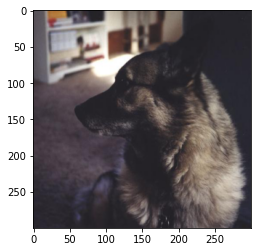

In [134]:
plt.imshow(image)
plt.show()

In [135]:
#Data loader section

In [136]:
stanford_dataloader = DataLoader(stanford_dataset,batch_size=2,shuffle=False)

In [137]:
item = next(iter(stanford_dataloader))

Label is --> Norwegian_elkhound
Label is --> miniature_pinscher


In [138]:
type(item)

list

In [139]:
image,label = item[0],item[1]

In [140]:
image.shape

torch.Size([2, 300, 300, 3])

In [141]:
label

tensor([0, 1])

In [142]:
image[0].shape

torch.Size([300, 300, 3])

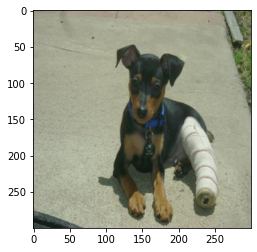

In [143]:
plt.imshow(image[1])
plt.show()

In [148]:
len(stanford_dataloader)

8232

In [151]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()


In [153]:
input.shape

torch.Size([3, 5])

In [154]:
target

tensor([0, 3, 1])

In [155]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

In [156]:
input.shape

torch.Size([3, 5])

In [157]:
target.shape

torch.Size([3, 5])